In [43]:
import os, sys
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import pickle
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import warnings


timepoint_generation_dict = {'t0_r1' : 0.0,
                             't1_r1' : 1.91,
                             't2_r1': 3.328354364,
                             't0_r2' : 0.0,
                             't1_r2' : 1.35,
                             't2_r2' : 2.96,
                             't0_control' : 0.0,
                             't1_control' : 2.022367813,
                             't2_control' : 3.50041511
                            }

allele_data = pickle.load(open('./input_output_files/input/allele_dic_with_WT.pkl', 'rb'))
# aminotonumber_data = pickle.load(open('./input_output_files/input/aminotonumber.pkl', 'rb'))
translate_data_RNA = pickle.load(open('./input_output_files/input/translate.pkl', 'rb'))

In [36]:
def get_timepoint_counts(filename):
    thrown_out_reads = 0.0
    f = open(filename)
    df = pd.DataFrame()
    barcodes = {}
    line_count = 0.0
    for line in f:
        line_count += 1.0
        barcode_forward = Seq(line.strip()[0:18])
        if 'N' not in barcode_forward:
            barcode_backward = str(barcode_forward.reverse_complement())
    #         barcodes.append(line.strip()[0:18])
            if barcode_backward in barcodes:
                barcodes[barcode_backward] += 1.0
            else:
                barcodes[barcode_backward] = 1.0
        else:
            thrown_out_reads += 1.0
    for barcode in barcodes:
        barcodes[barcode] = barcodes[barcode] / line_count
        
    return barcodes, line_count, thrown_out_reads
#         print(line)

def get_timepoints(replicate, test_run = False):
    thrown_out_N_reads_replicate = 0.0
    total_reads_replicate = 0.0
    replicate_barcode_timepoints = {}
    
    print('-------------------------------------------------------')
    print('GROUPING TIMEPOINTS FOR REPLICATE: ' + replicate + ' (' +str(datetime.now())+ ')')
    
    sys.stdout.flush()
    for time_point in ['t0', 't1', 't2']:
        
        print('\tSCRAPING TIMEPOINT: ' + time_point  + ' (' +str(datetime.now())+ ')')
        sys.stdout.flush()
        timepoint_lookup_key = time_point + '_' + replicate
        gen_value = timepoint_generation_dict[timepoint_lookup_key]
        if test_run:
            f = './input_output_files/input/' + timepoint_lookup_key +'_lines_short.txt'
        else:
            f = './input_output_files/input/' + timepoint_lookup_key +'_lines.txt'
        timepoint_barcodes, timepoint_total_count, thrown_out_reads = get_timepoint_counts(f)
        thrown_out_N_reads_replicate += thrown_out_reads
        total_reads_replicate += timepoint_total_count
        for barcode in timepoint_barcodes:
            barcode_timepoint_count = timepoint_barcodes[barcode]
            if barcode in replicate_barcode_timepoints:
                replicate_barcode_timepoints[barcode][gen_value] = barcode_timepoint_count
            else:
                replicate_barcode_timepoints[barcode] = {gen_value : barcode_timepoint_count}
            
            
    # Now check if you have readings for every timepoint (even if the reading is zero). 
    # If not, fill out the dictionary with zero readings for the preceeding timepoints
    print('CLEANING UP REPLICATE DATA...' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    for barcode in replicate_barcode_timepoints:
        if len(replicate_barcode_timepoints[barcode]) < 3:
            for time_point in ['t0', 't1', 't2']:
                timepoint_lookup_key = time_point + '_' + replicate
                gen_value = timepoint_generation_dict[timepoint_lookup_key]
                if gen_value not in replicate_barcode_timepoints[barcode]:
                    replicate_barcode_timepoints[barcode][gen_value] = 0.0 / timepoint_total_count

    save_name = replicate + '_' + f.split('_')[-1].replace('.txt', '_data.pkl')
    save_name = save_name.replace('lines', 'full')
            
    print('...DONE' + ' (' +str(datetime.now())+ ')')
    print('-------------------------------------------------------')
    sys.stdout.flush()
    counts = (timepoint_total_count, thrown_out_N_reads_replicate)
    return replicate_barcode_timepoints, counts, save_name

def get_raw_barcode_scores(replicate_barcode_timepoints):
    print('-------------------------------------------------------')
    print('CALCULATING SCORES FOR EACH BARCODE' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    replicate_barcode_scores = {}
    for barcode in replicate_barcode_timepoints:
        temp_x = list(replicate_barcode_timepoints[barcode].keys())
        temp_y =  list(replicate_barcode_timepoints[barcode].values())
        temp_y = np.log(temp_y)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(temp_x,temp_y)
        replicate_barcode_scores[barcode] = (slope, r_value**2.0)
    
    print('...DONE' + ' (' +str(datetime.now())+ ')')
    print('-------------------------------------------------------')
    sys.stdout.flush()
    return replicate_barcode_scores
    
def map_barcode_to_AA(raw_barcode_scores):
    AA_scores = {}
    WT_score_avg = 0.0
    thrown_out_dictionary_reads = 0.0
    print('-------------------------------------------------------')
    print('MAPPING BARCODE SCORES TO CODON SCORES' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    
    
    print('\tAGGREGATING SCORES' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    for barcode in raw_barcode_scores:
        if barcode in allele_data:
            loc, DNA_codon = allele_data[barcode]
            if DNA_codon != 'WT':
                RNA_codon = DNA_codon.replace('T', 'U')
                AA = translate_data_RNA[RNA_codon]
                index_tup = (loc, AA)
            else:
                index_tup = (loc, 'WT')
            
            if index_tup in AA_scores:
                AA_scores[index_tup]['score'].append(raw_barcode_scores[barcode][0])
                AA_scores[index_tup]['r^2'].append(raw_barcode_scores[barcode][1])
            else:
                AA_scores[index_tup] = {'score' : [raw_barcode_scores[barcode][0]], 
                                                       'r^2' : [raw_barcode_scores[barcode][1]]}
        else: 
            thrown_out_dictionary_reads += 1.0
            
            
    print('\tAVERAGING AA SCORES' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    for index_tup in AA_scores:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            score_avg = np.nanmean(AA_scores[index_tup]['score'])
            r2_avg = np.nanmean(AA_scores[index_tup]['r^2'])
        AA_scores[index_tup] = {'score' : score_avg, 'r2' : r2_avg}
        if index_tup[1] == 'WT':
            WT_score_avg = score_avg
        
    print('\tNORMALIZING BY WILDTYPE' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    
#     print(WT_score_avg, np.isnan(WT_score_avg))
    if np.isnan(WT_score_avg):
        WT_score_avg = 0.0
    for index_tup in AA_scores:
        AA_scores[index_tup]['score'] = AA_scores[index_tup]['score'] - WT_score_avg
#         print(AA_scores[index_tup])
        
    
    
    print('...DONE' + ' (' +str(datetime.now())+ ')')
    print('-------------------------------------------------------')
    sys.stdout.flush()
    
    return AA_scores, thrown_out_dictionary_reads


def save_data(AA_scores, counts, thrown_out_dictionary_reads, filename):
    print('-------------------------------------------------------')
    print('CREATING SAVE DATAFRAME' + ' (' +str(datetime.now())+ ')')
    sys.stdout.flush()
    
    (total_reads, thrown_out_N_reads) = counts
    
    save_tup = (AA_scores, total_reads, thrown_out_N_reads, thrown_out_dictionary_reads)
    print('SAVING TO FILE: ' + filename + ' (' +str(datetime.now())+ ')')
    pickle.dump(save_tup, open('./input_output_files/output/' + filename, 'wb'))
    
    
    print('...DONE' + ' (' +str(datetime.now())+ ')')
    print('-------------------------------------------------------')
    sys.stdout.flush()
    return
    
    
    
def plot_scores(AA_scores):
    locs = []
    AAs = []
    scores = []
    
#     for loc in range(76):
#         for AA in set(translate_data_RNA.values()):
#             if (loc, AA)
    
    for (loc, AA) in AA_scores:
        locs.append(loc)
        AAs.append(AA)
        scores.append(AA_scores[(loc, AA)]['score'])
# #     print(len(scores), len(AAs), len(locs))

#     print(np.amax(locs))
    plotting_df = pd.DataFrame()
    
    plotting_df['Location'] = locs
    plotting_df['AA'] = AAs
    plotting_df['score'] = scores
    plotting_df = plotting_df.pivot(index='AA', columns='Location', values='score')
#     print(plotting_df)
    
#     X,Y = np.meshgrid(locs,AAs)
#     Z = scores
#     plt.pcolormesh(X,Y,Z)
    sns.heatmap(plotting_df)
    plt.show()

In [37]:
def calc_data(replicate, test_run = False):
    replicate_barcode_timepoints, counts, save_name = get_timepoints(replicate, test_run = test_run)
    replicate_barcode_scores = get_raw_barcode_scores(replicate_barcode_timepoints)
    AA_scores, thrown_out_dictionary_reads = map_barcode_to_AA(replicate_barcode_scores)
    save_data(AA_scores, counts, thrown_out_dictionary_reads, save_name)
    return AA_scores, counts, thrown_out_dictionary_reads
    
replicate = 'control'
calc_data('control', test_run = True)

-------------------------------------------------------
GROUPING TIMEPOINTS FOR REPLICATE: control (2016-10-22 21:55:48.266067)
	SCRAPING TIMEPOINT: t0 (2016-10-22 21:55:48.266912)
	SCRAPING TIMEPOINT: t1 (2016-10-22 21:55:48.280866)
	SCRAPING TIMEPOINT: t2 (2016-10-22 21:55:48.298214)
CLEANING UP REPLICATE DATA... (2016-10-22 21:55:48.316718)
...DONE (2016-10-22 21:55:48.322234)
-------------------------------------------------------
-------------------------------------------------------
CALCULATING SCORES FOR EACH BARCODE (2016-10-22 21:55:48.323088)
...DONE (2016-10-22 21:55:49.704339)
-------------------------------------------------------
-------------------------------------------------------
MAPPING BARCODE SCORES TO CODON SCORES (2016-10-22 21:55:49.704874)
	AGGREGATING SCORES (2016-10-22 21:55:49.705323)
	AVERAGING AA SCORES (2016-10-22 21:55:49.709829)
	NORMALIZING BY WILDTYPE (2016-10-22 21:55:49.781889)
...DONE (2016-10-22 21:55:49.783056)
---------------------------------

({(0, 'WT'): {'r2': nan, 'score': nan},
  (3, 'A'): {'r2': nan, 'score': nan},
  (3, 'C'): {'r2': nan, 'score': nan},
  (3, 'V'): {'r2': nan, 'score': nan},
  (5, 'C'): {'r2': nan, 'score': nan},
  (5, 'L'): {'r2': nan, 'score': nan},
  (5, 'STOP'): {'r2': nan, 'score': nan},
  (6, 'C'): {'r2': nan, 'score': nan},
  (6, 'F'): {'r2': nan, 'score': nan},
  (6, 'G'): {'r2': 0.33599860390357489, 'score': -0.047075784981161606},
  (6, 'I'): {'r2': 0.0039979058553624288, 'score': 0.020364010470540983},
  (6, 'L'): {'r2': nan, 'score': nan},
  (6, 'N'): {'r2': nan, 'score': nan},
  (6, 'S'): {'r2': nan, 'score': nan},
  (6, 'T'): {'r2': nan, 'score': nan},
  (6, 'V'): {'r2': nan, 'score': nan},
  (6, 'Y'): {'r2': nan, 'score': nan},
  (7, 'A'): {'r2': nan, 'score': nan},
  (7, 'E'): {'r2': nan, 'score': nan},
  (7, 'G'): {'r2': 0.41156563260541712, 'score': 0.10330862604349919},
  (7, 'N'): {'r2': 0.0079958117107248577, 'score': 0.020364010470540983},
  (7, 'P'): {'r2': 0.66887292307844082, '

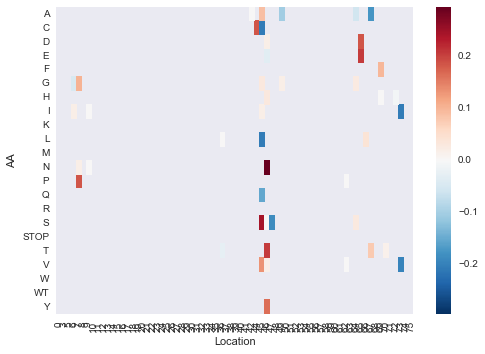

In [38]:
# print(AA_scores)
plot_scores(AA_scores)

In [44]:
aminotonumber_data

{'A': 9,
 'C': 8,
 'D': 19,
 'E': 20,
 'F': 2,
 'G': 10,
 'H': 16,
 'I': 5,
 'K': 18,
 'L': 4,
 'M': 6,
 'N': 14,
 'P': 11,
 'Q': 15,
 'R': 17,
 'S': 12,
 'STOP': 0,
 'T': 13,
 'V': 7,
 'W': 1,
 'Y': 3}